# Preprocessing ISIC Dataset
## 1. Training Data
### 1.1. Imports and load ground truth 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt


# Load ground truth
gt=pd.read_csv('ISIC2018_Task3_Training_GroundTruth.csv')

gt.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
#Convert csv to one array (ToDo: check conversion to numpy array and save the classes
Ytrain=gt['MEL']+ 2*gt['NV'] + 3*gt['BCC'] + 4*gt['AKIEC'] + 5*gt['BKL'] + 6*gt['DF'] + 7*gt['VASC']
Ytrain = Ytrain.astype(int)
Ytrain[0:20]

0     2
1     2
2     2
3     2
4     1
5     2
6     5
7     1
8     2
9     1
10    2
11    2
12    6
13    2
14    2
15    2
16    2
17    1
18    5
19    2
dtype: int32

In [3]:
def reduceDataset(Y,img_names, numClasses):
    counts = np.bincount(Y)
    counts= np.delete(counts, 0)
    print(counts)

    rare_value = np.argmin(counts)
    num_representations = counts[rare_value]

    print("Least represented value:", rare_value+1, "with",num_representations , "representations")

    
    counter = np.zeros((numClasses))
    img_index =  []
    newY=[]
    for index, elem in enumerate(Y):
        x = int(elem) -1
        if counter[x]< num_representations:
            img_index = np.append(img_index, (img_names[index] + ".jpg"))
            counter[x]+=1
            newY = np.append(newY, elem)
        if sum(counter)>= numClasses*num_representations:
            break
    print(img_index.size, "images left.")
    return img_index, newY

img_names = gt['image']

train_index, Ytrain = reduceDataset(Ytrain, img_names,7)

[1113 6705  514  327 1099  115  142]
Least represented value: 6 with 115 representations
805 images left.


### 1.2. Load data 

In [4]:
def loadPics(directory, x, y, index):
    data = []
    # Iterate through files in the specified directory
    for file in os.listdir(directory):
         # Check if the file is from type ".jpg"
         if file.endswith(".jpg") and file in index:
             #Take the image, resize it, covert it into an numpy array and append it to our data list
             img = Image.open(os.path.join(directory, file))
             img = img.resize((x,y))
             imgArray = np.array(img)
             data.append(imgArray)

    #Convert data list to np array
    data = np.array(data)
    return data

data1 = loadPics("ISIC2018_Task3_Training_Input", 60,45, train_index)
#Check the shape of our numpy data array
data1.shape

(805, 45, 60, 3)

### 1.3. Reshaping

In [5]:
#Reshape data in order to have one image per row
reshapeData = data1.reshape(data1.shape[0], data1.shape[1]*data1.shape[2]*data1.shape[3])
# Controll shape
reshapeData.shape

(805, 8100)

### 1.4. Normalization

In [6]:
#Normalize data by dividing by the maximum value of the pixels (255)
# Check if 255 is correct
normData = reshapeData / 255.
print('normData.min()', normData.min())
print('normData.max()', normData.max())

normData.min() 0.0
normData.max() 1.0


### 1.5. Mean removal

In [7]:
#Remove the mean from each pixel
normData = normData - normData.mean(axis=0)
# Control if the means are now approx. 0
normData.mean(axis=0)

array([ 1.00637235e-15, -4.08506907e-16,  1.79290675e-17, ...,
       -2.59695647e-16, -2.09563216e-16,  2.97208772e-17])

In [8]:
#Calculate the covariance matrix of the normalized data
cov = np.cov(normData, rowvar=False)
# Control shape of covariance matrix
cov.shape

(8100, 8100)

### 1.6. ZCA whitening

In [9]:
#Perform Singular Value Decomposition (SVD) on the covariance matrix 'cov'
U,S,V = np.linalg.svd(cov)

In [10]:
#Set a small constant 'epsilon' to avoid division by zero in the next step
epsilon = 0.1
# Perform Zero-phase Component Analysis whitening on the normalized data
DataZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(normData.T).T

In [11]:
#Rescale the ZCA-whitened data 'DataZCA' to the range [0, 1]
DataZCA_rescaled = (DataZCA - DataZCA.min()) / (DataZCA.max() - DataZCA.min())
print('min:', DataZCA_rescaled.min())
print('max:', DataZCA_rescaled.max())

min: 0.0
max: 1.0


### 1.7. Plot sample image

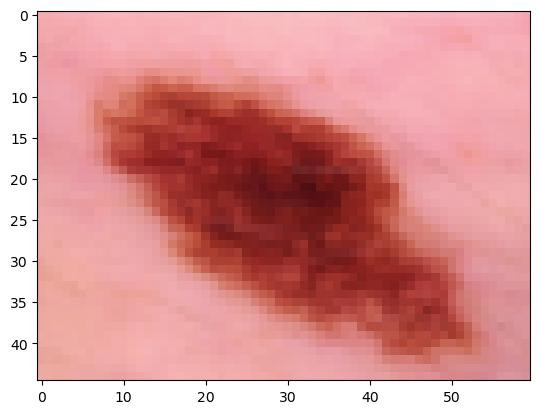

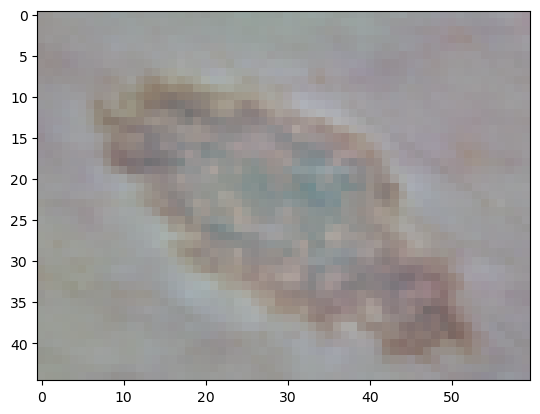

In [12]:
Xtrain = DataZCA_rescaled
#Function which takes a image of shape (1,4830) and plots it
x = 60
y = 45
def plotImage(X):
 plt.imshow(X.reshape(y,x,3))
 plt.show()
 plt.close()

#Plot third image before and after whitening
plotImage(reshapeData[2, :])
plotImage(Xtrain[2, :])

## 2. Test Data
### 2.1. Imports and load ground truth

In [13]:
# Load ground truth
Ytest=pd.read_csv('ISIC2018_Task3_Test_GroundTruth.csv')
test_names = Ytest['image']
#Convert csv to one array (ToDo: check conversion to numpy array and save the classes
Ytest=Ytest['MEL']+ 2*Ytest['NV'] + 3*Ytest['BCC'] + 4*Ytest['AKIEC'] + 5*Ytest['BKL'] + 6*Ytest['DF'] + 7*Ytest['VASC']
Ytest = Ytest.astype(int)

In [14]:
test_index, Ytest = reduceDataset(Ytest, test_names,7)

[171 909  93  43 217  44  35]
Least represented value: 7 with 35 representations
245 images left.


### 2.2. Load data

In [15]:
data2 = loadPics("ISIC2018_Task3_Test_Input", 60,45, test_index)
#Check the shape of our numpy data array
data2.shape

(245, 45, 60, 3)

### 2.3. Reshaping

In [16]:
#Reshape data in order to have one image per row
reshapeData2 = data2.reshape(data2.shape[0], data2.shape[1]*data2.shape[2]*data2.shape[3])
# Controll shape
print(reshapeData2.shape)

(245, 8100)


### 2.4. Normalization

In [17]:
#Normalize data by dividing by the maximum value of the pixels (255)
normData2 = reshapeData2 / 255
print('normData2.min()', normData2.min())
print('normData2.max()', normData2.max())

normData2.min() 0.0
normData2.max() 1.0


### 2.5. Mean Removal

In [18]:
#Remove the mean from each pixel
normData2 = normData2 - normData2.mean(axis=0)
# Control if the means are now approx. 0
print(normData2.mean(axis=0))

[ 4.07837029e-16  1.75596499e-16 -1.50446549e-16 ...  8.83646897e-17
 -1.81260902e-18  2.31107650e-16]


### 2.6. ZCA Whitening

In [19]:
#Calculate the covariance matrix of the normalized data
cov2 = np.cov(normData2, rowvar=False)
# Control shape of covariance matrix
print(cov2.shape)

#Perform Singular Value Decomposition (SVD) on the covariance matrix 'cov'
U2,S2,V2 = np.linalg.svd(cov2)
#Set a small constant 'epsilon' to avoid division by zero in the next step
epsilon = 0.1
# Perform Zero-phase Component Analysis whitening on the normalized data
DataZCA2 = U2.dot(np.diag(1.0/np.sqrt(S2 + epsilon))).dot(U2.T).dot(normData2.T).T
#Rescale the ZCA-whitened data 'DataZCA' to the range [0, 1]
DataZCA_rescaled2 = (DataZCA2 - DataZCA2.min()) / (DataZCA2.max() - DataZCA2.min())
print('min:', DataZCA_rescaled2.min())
print('max:', DataZCA_rescaled2.max())

(8100, 8100)
min: 0.0
max: 1.0


### 2.7. Plot sample image

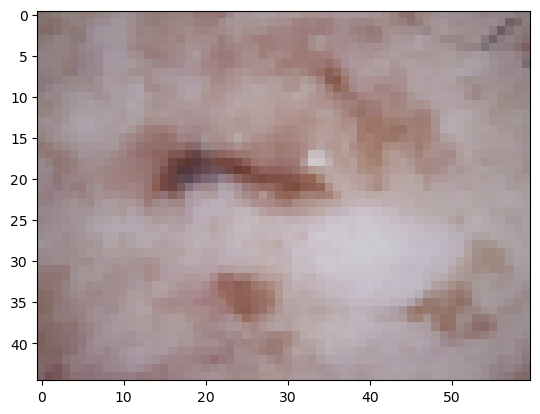

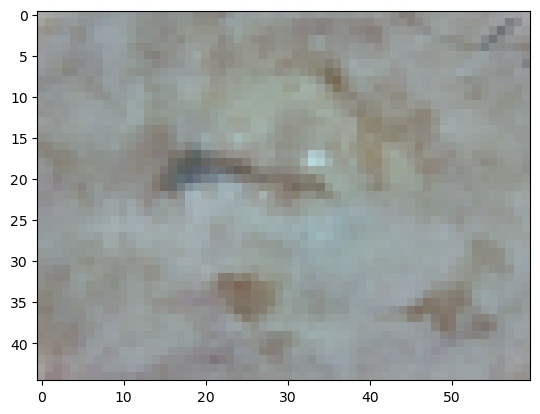

In [20]:
Xtest = DataZCA_rescaled2

#Plot third image before and after whitening
plotImage(reshapeData2[2, :])
plotImage(Xtest[2, :])

## 3. Save preprocessed data

In [22]:
# Save the NumPy array to an npy file
np.save('newTrainpics_preprocessed.npy', Xtrain)
np.save('newTestpics_preprocessed.npy', Xtest)
np.save('newTrainGT_preprocessed.npy', Ytrain)
np.save('newTestGT_preprocessed.npy', Ytest)